#Assigment 3: Identifying cracks and damages in structures (Concrete structures)
<br>42028 Deep Learning and Convolutional Neural Network - Autumn 2020

<br>Carlos Mario Carvajal Moreno. Student ID: 13144148
<br>Andres Felipe Lagos. Student ID: 13092248
<br>Ernest Ilustre.  Student ID: 12763239

In [1]:
#Connecting to Google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#Importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json

Using TensorFlow backend.


In [ ]:
cd /content/gdrive/My Drive/A3 

/content/gdrive/My Drive/A3


In [ ]:
ls

A3_CNN_Multiclass.ipynb  VGG16_A3_CNN_Pavement.ipynb  VGG19_A3_CNN_Wall.ipynb
Concrete_Data_Final.zip  VGG16_A3_CNN_Wall.ipynb      Weights/
multiclass_model.json    VGG19_A3_CNN_Deck.ipynb
VGG16_A3_CNN_Deck.ipynb  VGG19_A3_CNN_Pavement.ipynb


In [3]:
#Extraction of data and placing it in the temporary folder. The models work a lot better
local_zip = '/content/gdrive/My Drive/42028-DL-CNN-2020/Assignments/A3/Concrete_Data_Final.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
#Setting the path directory for training and validation sets
base_dir = '/tmp/Concrete_Data_Final'
train_dir = os.path.join(base_dir, 'Train/Pavement')
validation_dir = os.path.join(base_dir, 'Val/Pavement')
test_dir = os.path.join(base_dir, 'Test/Pavement')

#Train
# Directory with training Pavement Cracked Pictures
train_cracked_dir = os.path.join(train_dir, 'Cracked')
# Directory with training Pavement Uncracked Pictures
train_Uncracked_dir = os.path.join(train_dir, 'Uncracked')


#Val
# Directory with validation Pavement Cracked pictures
val_cracked_dir = os.path.join(validation_dir, 'Cracked')
# Directory with validation Pavement Uncracked pictures
val_Uncracked_dir = os.path.join(validation_dir, 'Uncracked')


#Test
# Directory with validation Pavement Cracked pictures
test_cracked_dir = os.path.join(test_dir, 'Cracked')
# Directory with validation Pavement Uncracked pictures
test_Uncracked_dir = os.path.join(test_dir, 'Uncracked')

In [5]:
# All images are rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   brightness_range = (0.9,1.1),
                                   fill_mode='nearest'
                                   )
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16
image_size = 256

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),  # Images are size 100X100
        batch_size= batch_size,
        class_mode='binary')

# Flow validation images in batches of 16 using test_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='binary')

# Flow validation images in batches of 16 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='binary')

Found 3744 images belonging to 2 classes.
Found 1067 images belonging to 2 classes.
Found 19523 images belonging to 2 classes.


In [ ]:
class_dict = train_generator.class_indices
class_dict

{'Cracked': 0, 'Uncracked': 1}

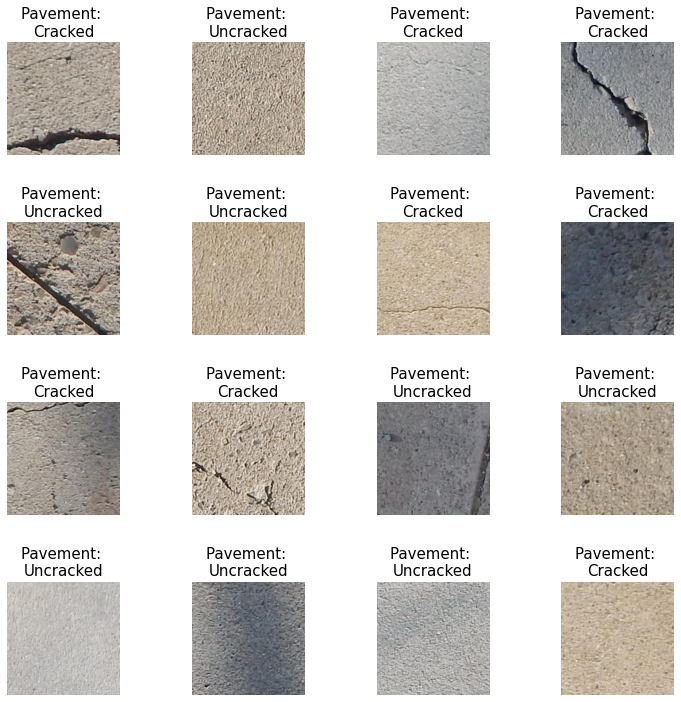

In [6]:
#Extracting classes and their indeces
class_dict = train_generator.class_indices

#Plotting the fruits randomly from train generator
generator_index = np.random.choice(validation_generator.n//validation_generator.batch_size, size=(16,))
image_pixels = 0 #0 is the index where the pixel values and the RGB values are stored in the generator
name_index = 1 #1 is the index where the one hot encoding for the labels are

plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.6, hspace=0.6)
for i in generator_index:
  images_inbatch = np.random.randint(batch_size)
  name = int(validation_generator[i][name_index][images_inbatch])
  plt.subplot(4,4,(np.where(generator_index == i)[0][0])+1)
  plt.imshow(validation_generator[i][image_pixels][images_inbatch])
  plt.title(label=('Pavement: \n{}'.format(list(class_dict.keys())[list(class_dict.values()).index(name)])), size=15)
  plt.axis('off')

In [ ]:
#Downloading the inception ResNet V2 model with imagenet weights
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.summary()
for layer in conv_base.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in conv_base.layers:
    print(layer, layer.trainable)


model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
#compiling the model
model.compile(optimizer= optimizers.RMSprop(learning_rate=0.001),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1, period=3)
filepath='/content/gdrive/My Drive/A3/Weights/Pavement_weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint= ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
json_string  = model.to_json()
f = open("pavement_model.json", 'w')
f.write(json_string)
f.close()

In [ ]:
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch= train_generator.n//train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps= validation_generator.n//train_generator.batch_size,
      callbacks = [checkpoint],
      verbose=1,
      )

Epoch 1/20
234/234 [==============================] - 72s 306ms/step - loss: 0.7082 - accuracy: 0.6450 - val_loss: 1.0009 - val_accuracy: 0.5691
Epoch 2/20
234/234 [==============================] - 64s 275ms/step - loss: 0.4932 - accuracy: 0.7772 - val_loss: 0.4672 - val_accuracy: 0.7383
Epoch 3/20
234/234 [==============================] - 63s 271ms/step - loss: 0.4517 - accuracy: 0.8021 - val_loss: 0.4304 - val_accuracy: 0.7878
Epoch 4/20
234/234 [==============================] - 63s 271ms/step - loss: 0.4296 - accuracy: 0.8130 - val_loss: 0.6299 - val_accuracy: 0.8354
Epoch 5/20
234/234 [==============================] - 63s 268ms/step - loss: 0.4311 - accuracy: 0.8149 - val_loss: 0.5232 - val_accuracy: 0.8487
Epoch 6/20
234/234 [==============================] - 62s 266ms/step - loss: 0.3875 - accuracy: 0.8403 - val_loss: 0.4660 - val_accuracy: 0.7916
Epoch 7/20
234/234 [==============================] - 62s 266ms/step - loss: 0.3876 - accuracy: 0.8379 - val_loss: 0.3309 - val_ac

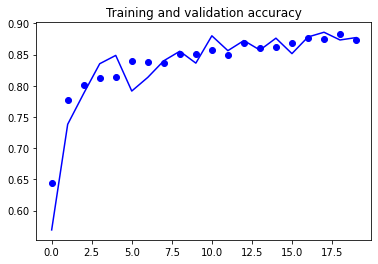

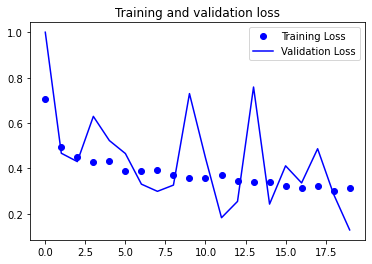

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
test_acc

1221/1221 [==============================] - 64s 52ms/step


0.8627772331237793

#Test

In [7]:
#Extraction of data and placing it in the temporary folder. The models work a lot better
local_zip = '//content/gdrive/My Drive/42028-DL-CNN-2020/Assignments/A3/A3_weights_final.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
from keras.models import load_model
#Uploading best weights
model2 = load_model('/content/A3_weights_final/Pavement_weights.19-0.18.hdf5')

In [10]:
test_loss, test_acc = model2.evaluate(test_generator)
test_acc

1221/1221 [==============================] - 70s 57ms/step


0.9191722869873047

In [11]:
y_pred = model2.predict(test_generator, steps = test_generator.n // batch_size+1)
classes = []

for i in y_pred:
  if i<0.5:
    classes.append(0)
  else:
    classes.append(1)

y_pred = np.array(classes)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

The number of correctly classified structures is 17547 out of 19523 test samples

 Correctly Classified samples
.


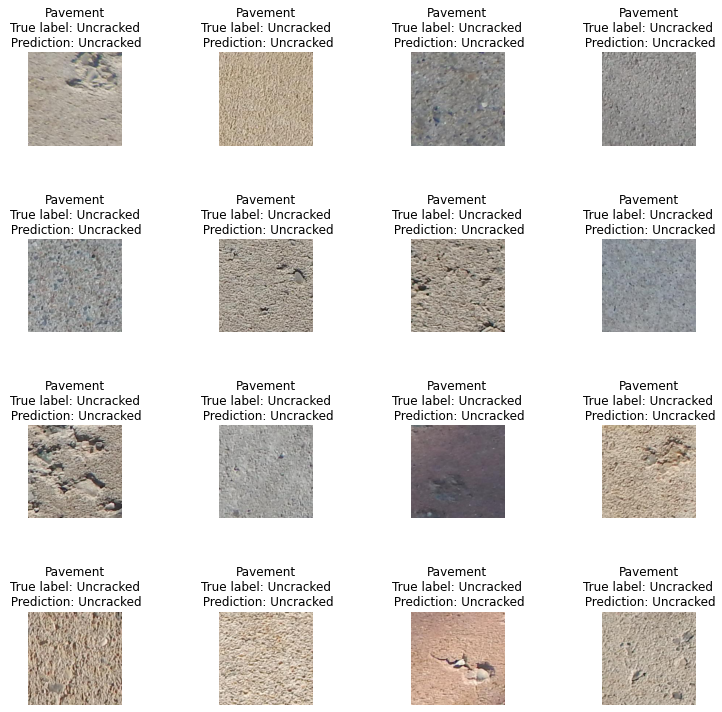

In [25]:
class_dict = test_generator.class_indices
misclassified_index = np.nonzero(test_generator.classes != y_pred)[0]
correct_index = np.nonzero(test_generator.classes == y_pred)[0]

print('The number of correctly classified structures is {} out of {} test samples'.\
      format(len(correct_index), test_generator.n))


print('\n Correctly Classified samples\n.')

random_images = np.random.choice(correct_index, size=(batch_size,))


plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=1, hspace=1)
for i in random_images:
  images_inbatch = i//batch_size
  index_inbatch = int((i/batch_size - i//batch_size)*batch_size)
  name = int(test_generator[images_inbatch][1][index_inbatch])
  pred = y_pred[i]
  plt.subplot(4,4, (np.where(random_images == i)[0][0])+1)
  plt.imshow(test_generator[images_inbatch][0][index_inbatch])
  plt.title("Pavement\nTrue label: {}\n Prediction: {}".format(list(class_dict.keys())[list(class_dict.values()).index(name)], 
                                                     list(class_dict.keys())[list(class_dict.values()).index(pred)]))
                                                
  plt.axis('off')

The number of incorrectly classified Structures is 1976 out of 19523 test samples

Misclassified Structures:
.
.


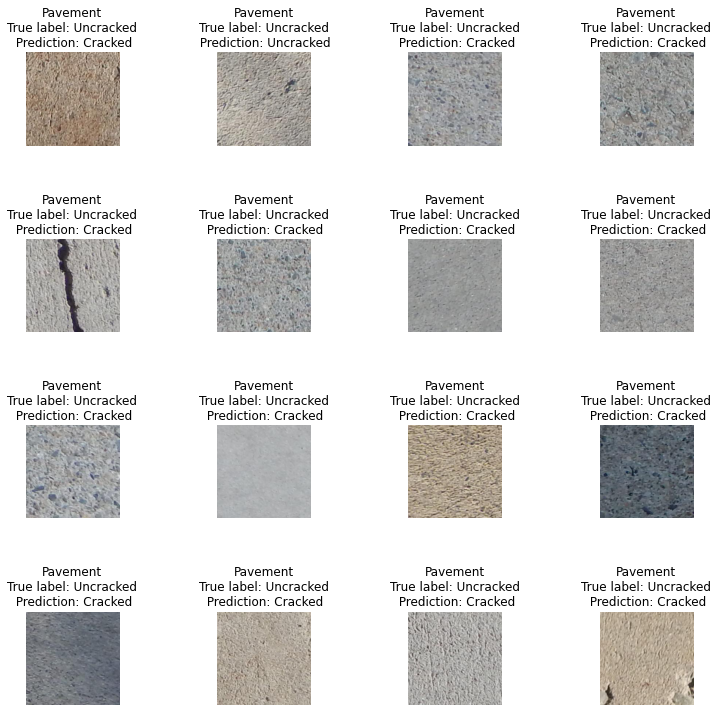

In [14]:
print('The number of incorrectly classified Structures is {} out of {} test samples'.\
      format(len(misclassified_index), test_generator.n))

print('\nMisclassified Structures:\n.\n.')

random_images = np.random.choice(misclassified_index, size=(batch_size,))


plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=1, hspace=1)
for i in random_images:
  images_inbatch = i//batch_size
  index_inbatch = int((i/batch_size - i//batch_size)*batch_size)
  name = int(test_generator[images_inbatch][1][index_inbatch])
  pred = y_pred[i]
  plt.subplot(4,4, (np.where(random_images == i)[0][0])+1)
  plt.imshow(test_generator[images_inbatch][0][index_inbatch])
  plt.title("Pavement\nTrue label: {}\n Prediction: {}".format(list(class_dict.keys())[list(class_dict.values()).index(name)], 
                                                     list(class_dict.keys())[list(class_dict.values()).index(pred)]))
                                                
  plt.axis('off')